In [ ]:
!pip install contractions

     |████████████████████████████████| 327kB 21.0MB/s 
     |████████████████████████████████| 286kB 47.9MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85388 sha256=7c63e6500d33cc52cd3165e373f3e6906b679ca5617aa3372b5c8bd6b6bae776
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [ ]:
import sys
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set_context('talk')
import missingno
from wordcloud import WordCloud, ImageColorGenerator

import os
import string
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import ngrams
import contractions

import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,GRU,Bidirectional,BatchNormalization,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,TensorBoard

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Natural Disaster/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Natural Disaster/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/Natural Disaster/sample_submission.csv')

df = train.copy()
df_test = test.copy()
df.head()

id keyword  ...                                               text target
0   1     NaN  ...  Our Deeds are the Reason of this #earthquake M...      1
1   4     NaN  ...             Forest fire near La Ronge Sask. Canada      1
2   5     NaN  ...  All residents asked to 'shelter in place' are ...      1
3   6     NaN  ...  13,000 people receive #wildfires evacuation or...      1
4   7     NaN  ...  Just got sent this photo from Ruby #Alaska as ...      1

[5 rows x 5 columns]

In [ ]:
print(f'Length of training data : {str(len(df))}')
print(f'Length of testing data : {str(len(df_test))}')

Length of training data : 7613
Length of testing data : 3263


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
def missing_data(df) :
    print('Missind Data %')
    print(np.round(df.isnull().sum() / len(df) * 100 , 2))
    missingno.matrix(df,figsize=(8,3));

Missind Data %
id           0.00
keyword      0.80
location    33.27
text         0.00
target       0.00
dtype: float64


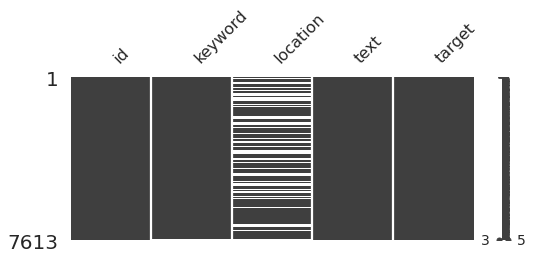

In [ ]:
missing_data(df)

In [ ]:
def handle_missing_data(df) :
    df['keyword'] = df['keyword'].fillna('no_keyword')
    df['location'] = df['location'].fillna('no_location')  
    return df

In [ ]:
df = handle_missing_data(df)

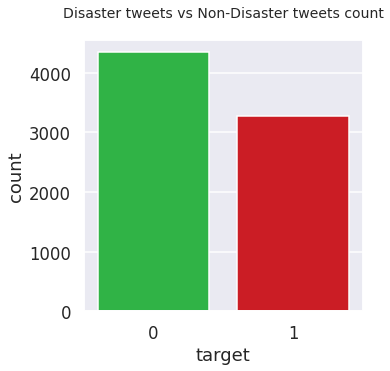

In [ ]:
plt.figure(figsize=(5,5))
sns.countplot(df['target'],palette=sns.color_palette("bright")[2:4]);
plt.title('Disaster tweets vs Non-Disaster tweets count\n' , fontsize=14,);

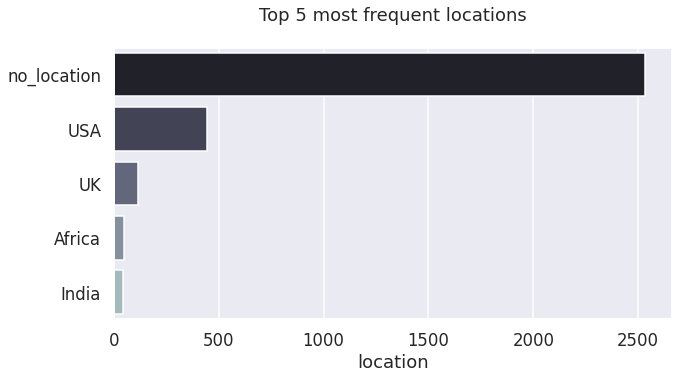

In [ ]:
df['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)
plt.figure(figsize=(10,5))
sns.barplot(y = df['location'].value_counts()[:5].index, x = df['location'].value_counts()[:5],orient='h',palette=sns.color_palette("bone"));
plt.title('Top 5 most frequent locations\n',fontsize=18);

In [ ]:
df_disaster = df[df['target'] == 1]
df_not_disaster = df[df['target'] == 0]

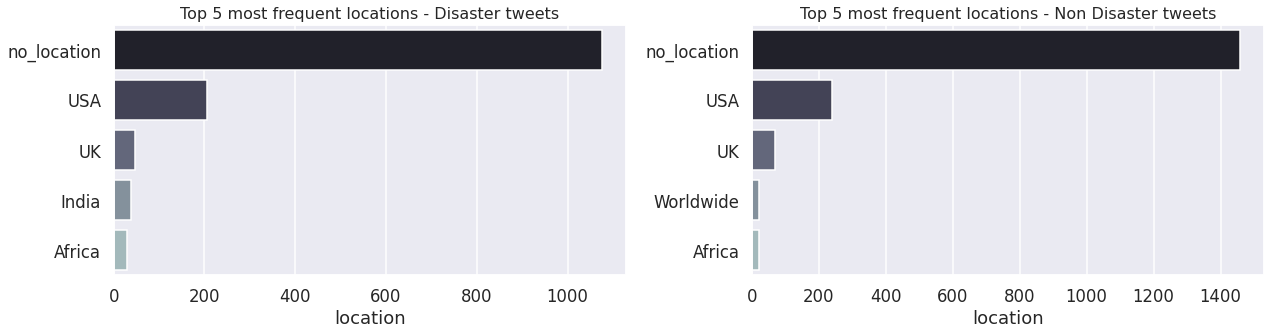

In [ ]:
plt.figure(figsize=(18,5))
plt.subplot(1, 2, 1);
plt.title('Top 5 most frequent locations - Disaster tweets',fontsize=16);
sns.barplot(y = df_disaster['location'].value_counts()[:5].index, x = df_disaster['location'].value_counts()[:5],orient='h',palette=sns.color_palette("bone"));
plt.tight_layout();
plt.subplot(1, 2, 2);
plt.title('Top 5 most frequent locations - Non Disaster tweets',fontsize=16);
sns.barplot(y = df_not_disaster['location'].value_counts()[:5].index, x = df_not_disaster['location'].value_counts()[:5],orient='h',palette=sns.color_palette("bone"));
plt.tight_layout();

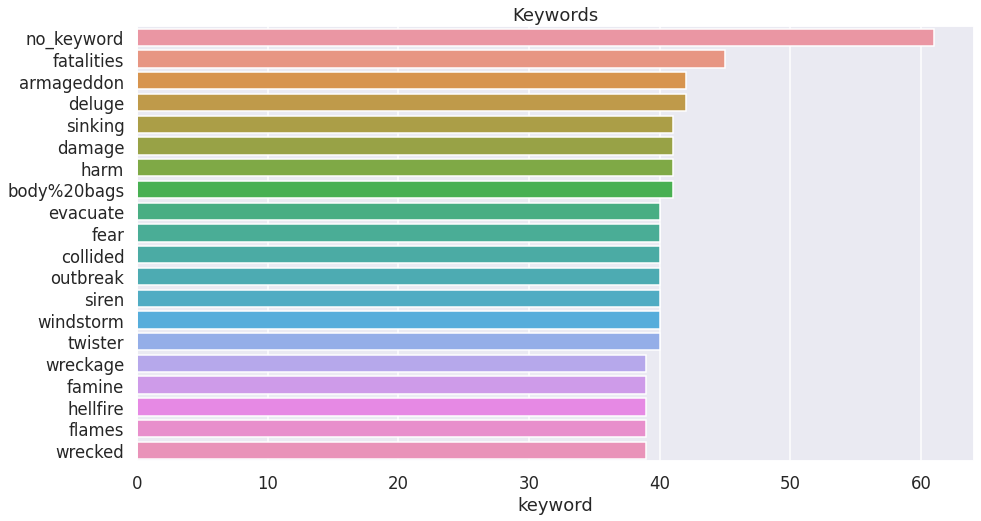

In [ ]:
plt.figure(figsize=(15,8));
sns.barplot(y = df['keyword'].value_counts()[:20].index, x = df['keyword'].value_counts()[:20],orient='h');
plt.title('Keywords',fontsize=18);

In [ ]:
df_disaster = df[df['target'] == 1]
df_not_disaster = df[df['target'] == 0]

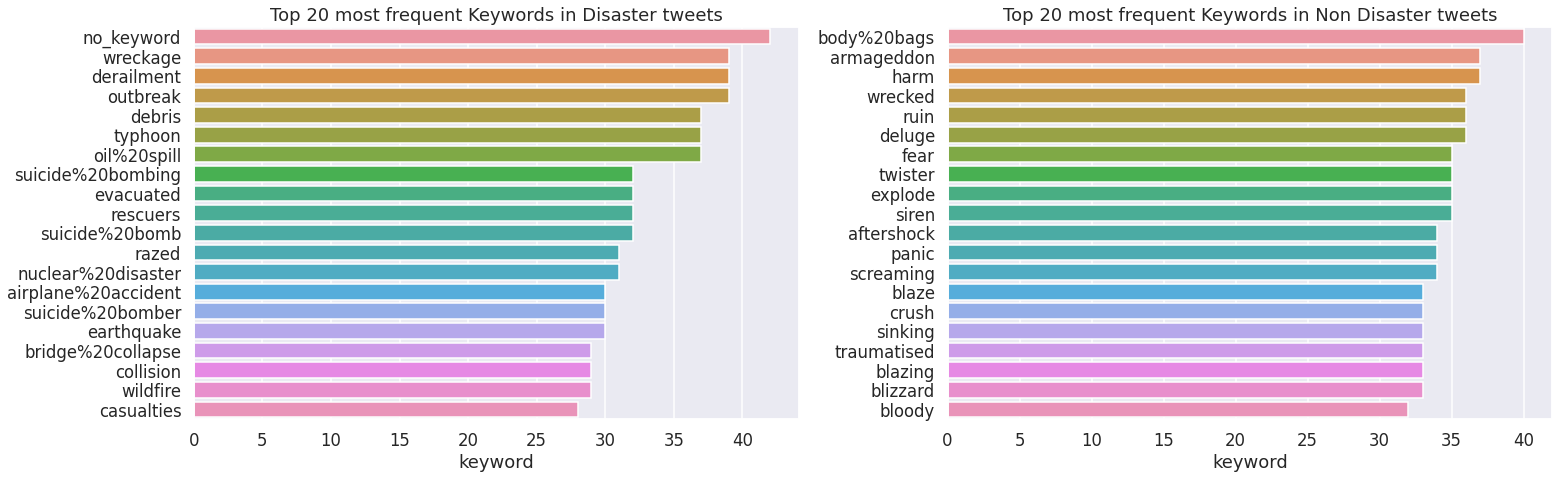

In [ ]:
plt.figure(figsize=(22,7))
plt.subplot(1, 2, 1);
sns.barplot(y = df_disaster['keyword'].value_counts()[:20].index, x = df_disaster['keyword'].value_counts()[:20],orient='h');
plt.title('Top 20 most frequent Keywords in Disaster tweets',fontsize=18);
plt.tight_layout();
plt.subplot(1, 2, 2);
sns.barplot(y = df_not_disaster['keyword'].value_counts()[:20].index, x = df_not_disaster['keyword'].value_counts()[:20],orient='h');
plt.title('Top 20 most frequent Keywords in Non Disaster tweets',fontsize=18);
plt.tight_layout();

In [ ]:
def df_analysis(df,col) :
    df['num_chars'] = df[col].apply(lambda x : len(str(x)))
    df['num_words'] = df[col].apply(lambda x : len(str(x).split()))
    df['num_sents'] = df[col].apply(lambda x : len([i for i in re.split('\\.|\n',x) if len(i) > 1]))
    df['num_unique_words'] = df[col].apply(lambda x : len(set(str(x).split())))
    df['num_stopwords'] = df[col].apply(lambda x : len(list(set(str(x).lower().split()).difference(stopwords.words('english')))))
    df['num_punct'] = df[col].apply(lambda x : len([i for i in str(x) if i in string.punctuation]))
    df['mean_word_length'] = df[col].apply(lambda x : np.mean([len(i) for i in str(x).split()]))
    df['num_urls'] = df[col].apply(lambda x : len([i for i in str(x).lower().split() if 'http' in i or 'https' in i]))
    df['num_#'] = df[col].apply(lambda x: len([i for i in str(x) if i == '#']))
    df['num_@'] = df[col].apply(lambda x: len([i for i in str(x) if i == '@']))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF" 
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF" 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    df['num_emoji_symbols_etc'] = df[col].apply(lambda x : len(emoji.findall(x)))
    return df

In [ ]:
df.head()

id     keyword  ...                                               text target
0   1  no_keyword  ...  Our Deeds are the Reason of this #earthquake M...      1
1   4  no_keyword  ...             Forest fire near La Ronge Sask. Canada      1
2   5  no_keyword  ...  All residents asked to 'shelter in place' are ...      1
3   6  no_keyword  ...  13,000 people receive #wildfires evacuation or...      1
4   7  no_keyword  ...  Just got sent this photo from Ruby #Alaska as ...      1

[5 rows x 5 columns]

In [ ]:
df = df_analysis(df,'text')
df.head(2)

id     keyword     location  ... num_#  num_@  num_emoji_symbols_etc
0   1  no_keyword  no_location  ...     1      0                      0
1   4  no_keyword  no_location  ...     0      0                      0

[2 rows x 16 columns]

In [ ]:
def plot_analysis(df , group_col , cols) :
    colors = ['BuPu','Paired_r','Paired_r','Paired_r','Set1','Set1','Set1','hsv','gist_yarg','rocket_r','Set3_r']
    color_idx = [[3,5],[1,3],[2,4],[3,5],[0,2],[3,5],[7,9],[2,4],[3,5],[4,6],[1,3]]
    c = 0
    for col in cols :
        mean = df.groupby(group_col)[col].mean()
        plt.figure(figsize=(20,5));
        plt.subplot(1, 4, 1);
        plt.title(f'\n{col.upper()} ANALYSIS\n',loc='left',fontsize=18);
        sns.histplot(data=df, x=col, hue=group_col,palette = sns.color_palette(colors[c])[color_idx[c][0]:color_idx[c][1]]);
        plt.subplot(1, 4, 2);
        sns.violinplot(x=group_col,y=col,data=df,palette = sns.color_palette(colors[c])[color_idx[c][0]:color_idx[c][1]]);
        plt.tight_layout();
        plt.subplot(1, 4, 3);
        sns.barplot(x=mean.index,y=mean.values,palette = sns.color_palette(colors[c])[color_idx[c][0]:color_idx[c][1]]);
        plt.tight_layout();
        plt.subplot(1, 4, 4);
        sns.kdeplot(x=col,shade=True,data=df,hue=group_col,palette = sns.color_palette(colors[c])[color_idx[c][0]:color_idx[c][1]]);
        plt.tight_layout()
        c += 1

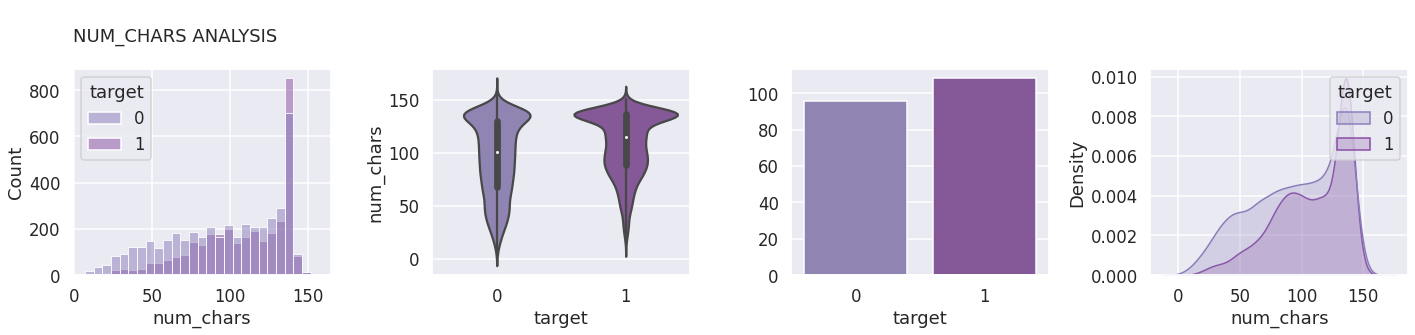

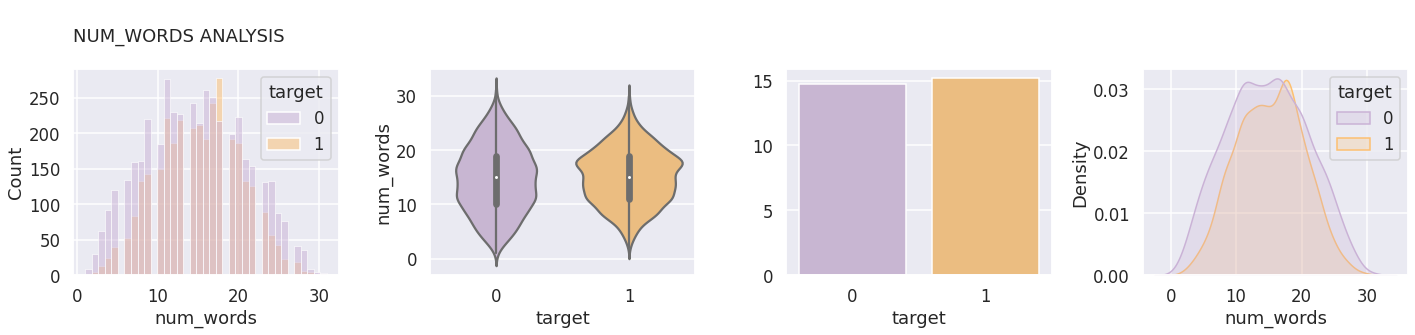

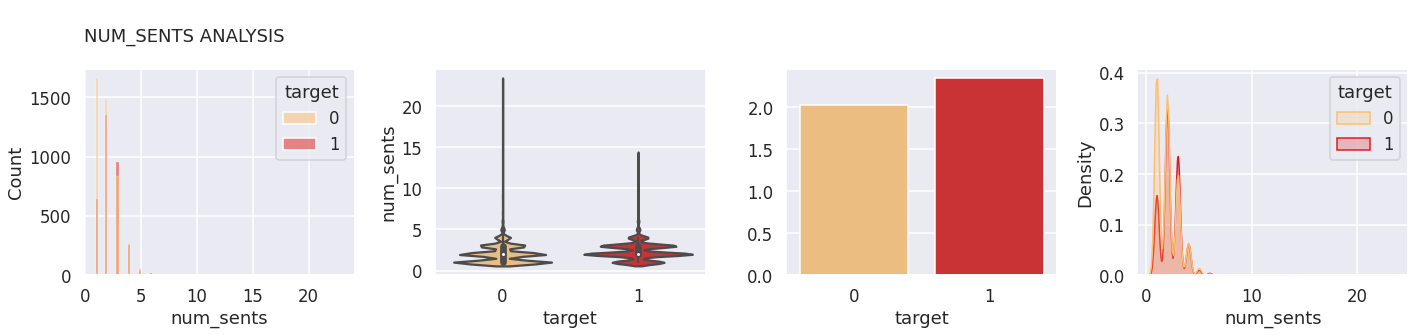

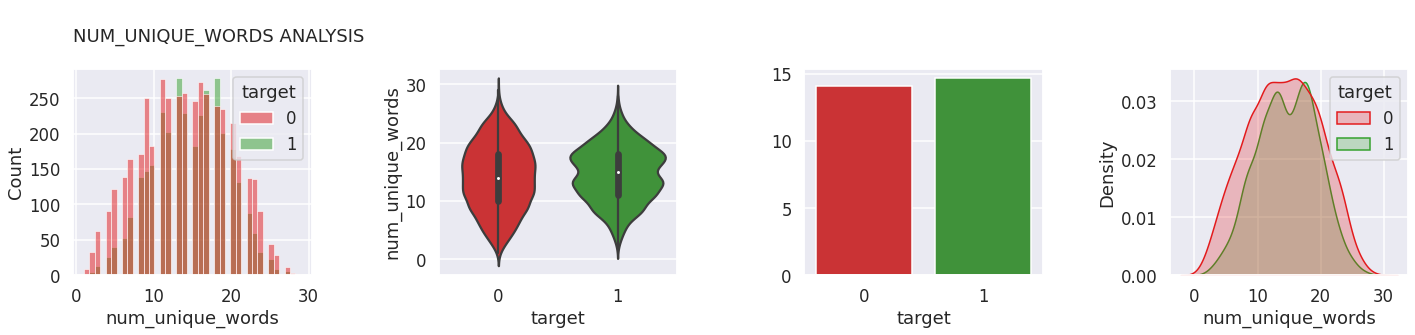

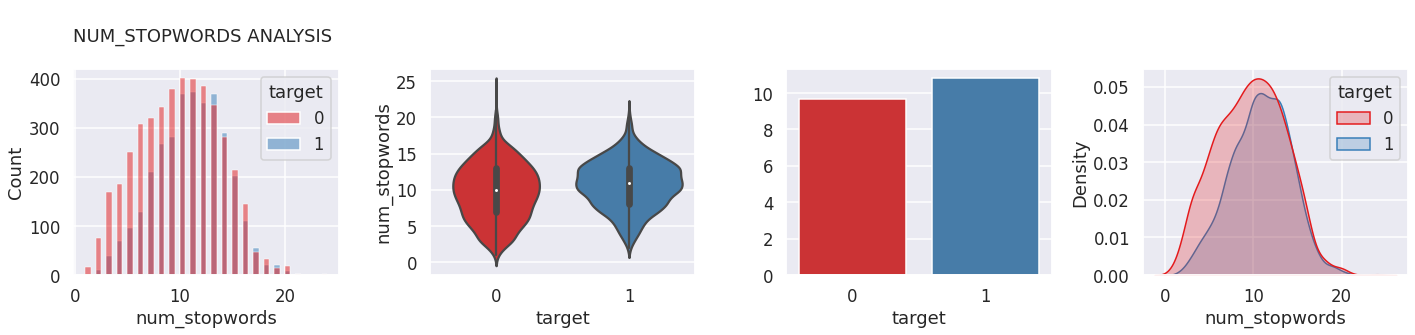

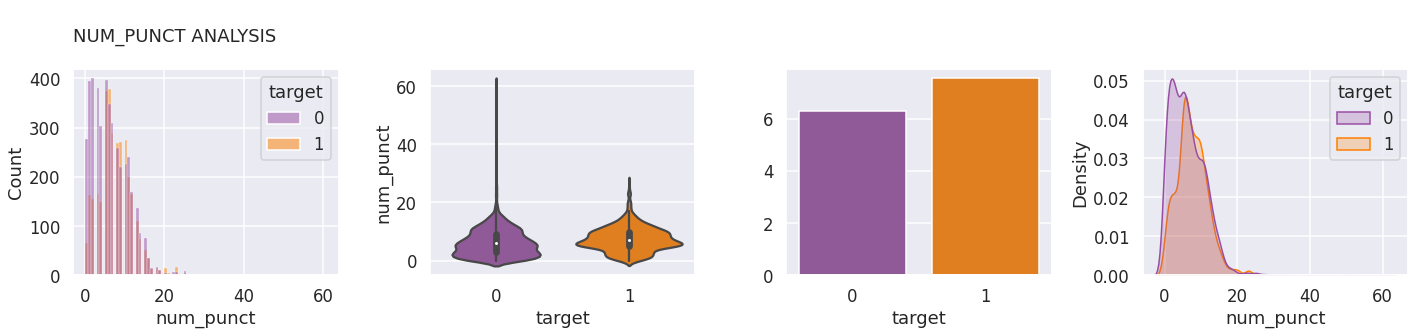

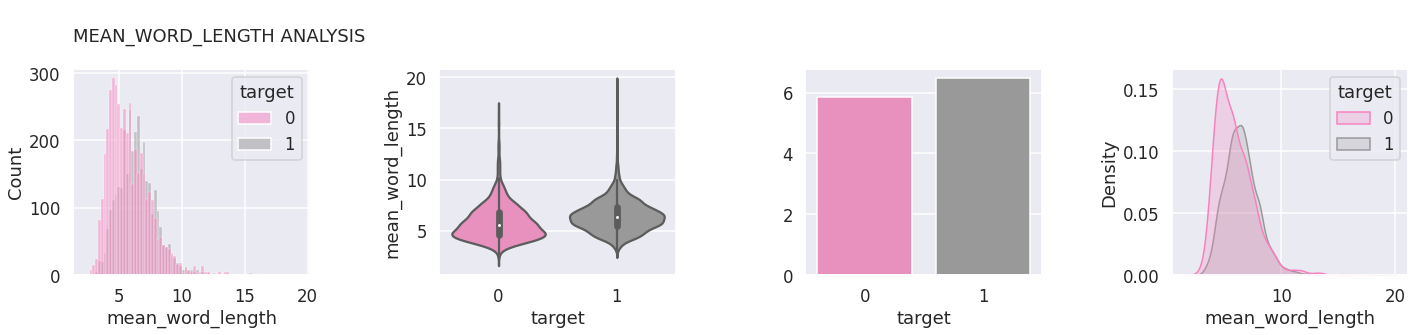

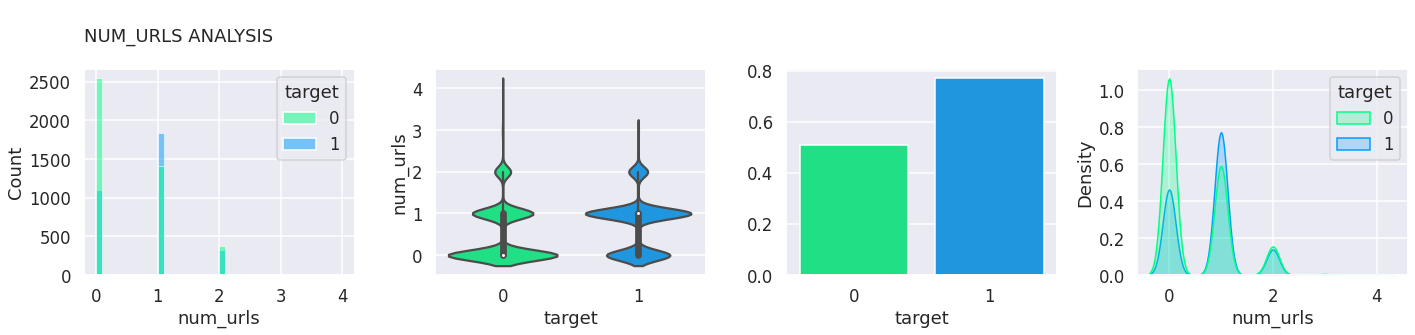

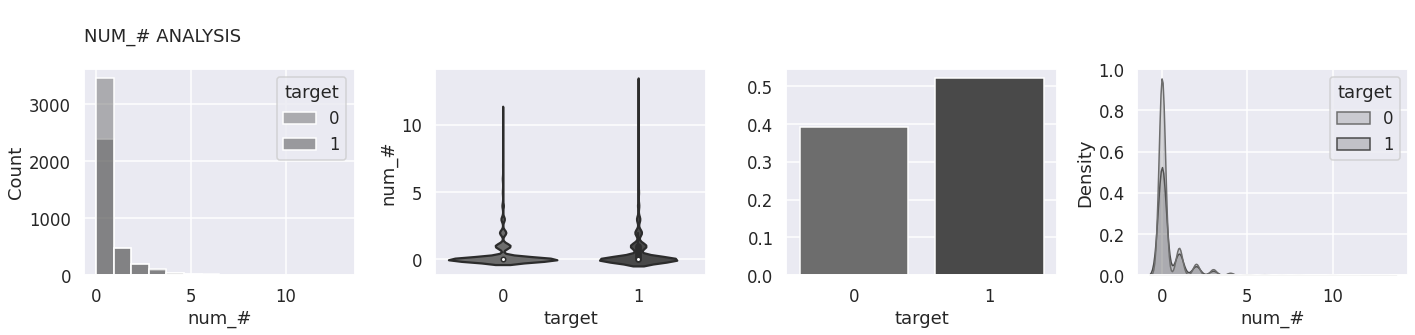

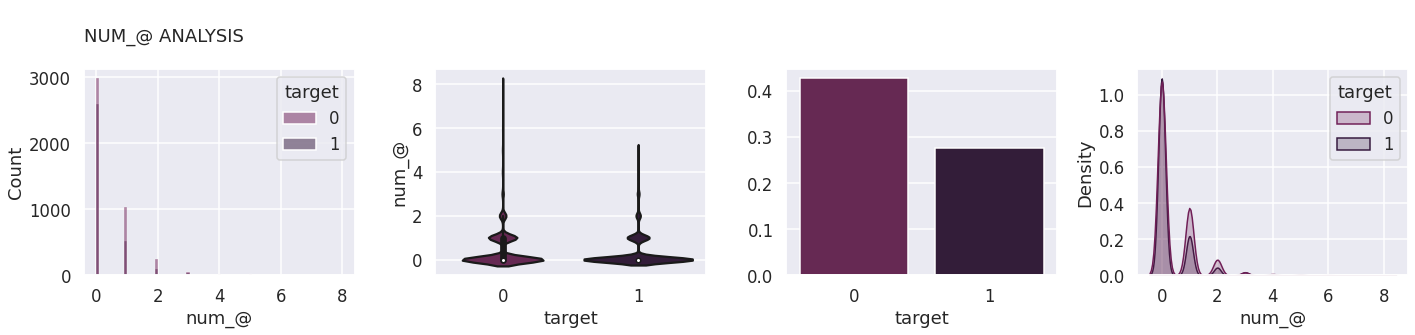

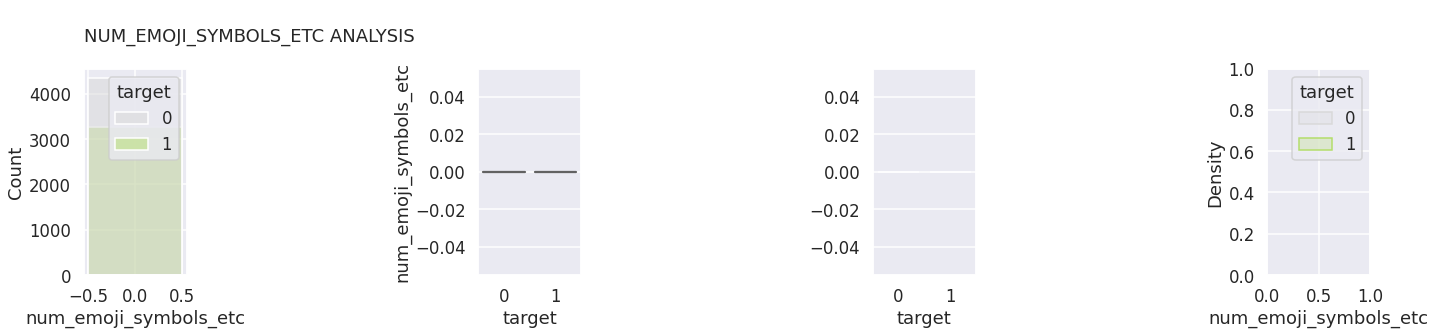

In [ ]:
c = ['num_chars', 'num_words','num_sents', 'num_unique_words', 
     'num_stopwords', 'num_punct','mean_word_length', 'num_urls', 
     'num_#', 'num_@','num_emoji_symbols_etc']
plot_analysis(df,'target', c)

In [ ]:
def text_preprocessing(content) :
    corpus = []
    for line in content :
        text = line.lower()
        pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        text = pattern.sub('', text)
        text = " ".join(filter(lambda x:x[0]!='@', text.split()))
        emoji = re.compile("["u"\U0001F600-\U0001FFFF" u"\U0001F300-\U0001F5FF" u"\U0001F680-\U0001F6FF"   
                              u"\U0001F1E0-\U0001F1FF" u"\U00002702-\U000027B0" u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)     
        text = emoji.sub(r'', text)
        text = text.lower()
        text = ' '.join([contractions.fix(word) for word in text.split()])
        text = text.lower()
        text = re.sub(r"\'ve", " have", text)  
        text = re.sub(r"did't", "did not", text)
        text = re.sub(r"have't", "have not", text)
        text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
        tokens = word_tokenize(text)
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        words = [w.strip() for w in words if not w in stop_words]
        lemma = WordNetLemmatizer()
        words = [lemma.lemmatize(w) for w in words]
        corpus.append(words)
    return corpus

In [ ]:
df['final_text'] = df['text'] + ' | ' + df['location'] + ' | ' + df['keyword']
df.head(2)

id  ...                                         final_text
0   1  ...  Our Deeds are the Reason of this #earthquake M...
1   4  ...  Forest fire near La Ronge Sask. Canada | no_lo...

[2 rows x 17 columns]

In [ ]:
content = df['final_text'].values.tolist()
corpus = text_preprocessing(content)
corpus[:5]

[['deed',
  'reason',
  'earthquake',
  'may',
  'allah',
  'forgive',
  'u',
  'nolocation',
  'nokeyword'],
 ['forest',
  'fire',
  'near',
  'la',
  'ronge',
  'sask',
  'canada',
  'nolocation',
  'nokeyword'],
 ['resident',
  'asked',
  'shelter',
  'place',
  'notified',
  'officer',
  'evacuation',
  'shelter',
  'place',
  'order',
  'expected',
  'nolocation',
  'nokeyword'],
 ['people',
  'receive',
  'wildfire',
  'evacuation',
  'order',
  'california',
  'nolocation',
  'nokeyword'],
 ['got',
  'sent',
  'photo',
  'ruby',
  'alaska',
  'smoke',
  'wildfire',
  'pours',
  'school',
  'nolocation',
  'nokeyword']]

In [ ]:
def plot_wordcloud(corp_col , corp_val , text_col , title,df,bigram=False,trigram=False) :
    pos_data = df.loc[df[corp_col] == corp_val]
    corpus = text_preprocessing(pos_data[text_col].values.tolist())
    if bigram :
        bigram_corpus = []
        for i in corpus :
            t = []
            for j in range(len(i) - 1) :
                word = f'{str(i[j])}_{str(i[j + 1])}'
                t.append(word)
            bigram_corpus.append(t)
        corpus = bigram_corpus
    if trigram :
        trigram_corpus = []
        for i in corpus :
            t = []
            for j in range(len(i) - 2) :
                word = f'{str(i[j])}_{str(i[j + 1])}_{str(i[j + 2])}'
                t.append(word)
            trigram_corpus.append(t)
        corpus = trigram_corpus
    pos_lines = [j for sub in corpus for j in sub] 
    word_could_dict=Counter(pos_lines)

    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title,fontsize=40)

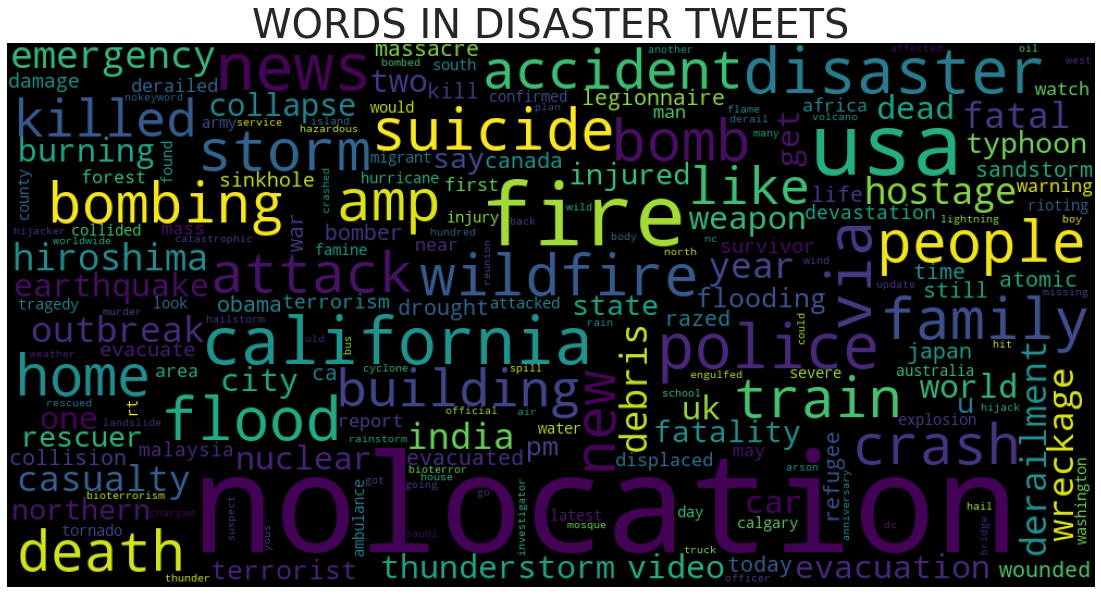

In [ ]:
plot_wordcloud(
    corp_col = 'target' ,
    corp_val = 1 ,
    text_col = 'final_text' ,
    title = 'WORDS IN DISASTER TWEETS',
    df = df
)

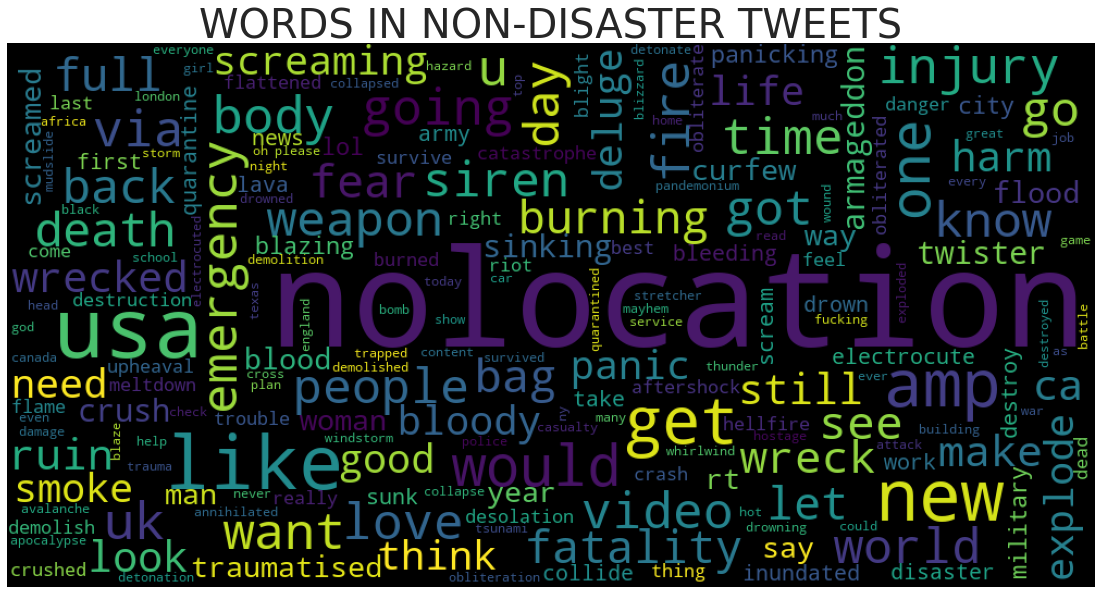

In [ ]:
plot_wordcloud(
    corp_col = 'target' ,
    corp_val = 0 ,
    text_col = 'final_text' ,
    title = 'WORDS IN NON-DISASTER TWEETS',
    df = df
)

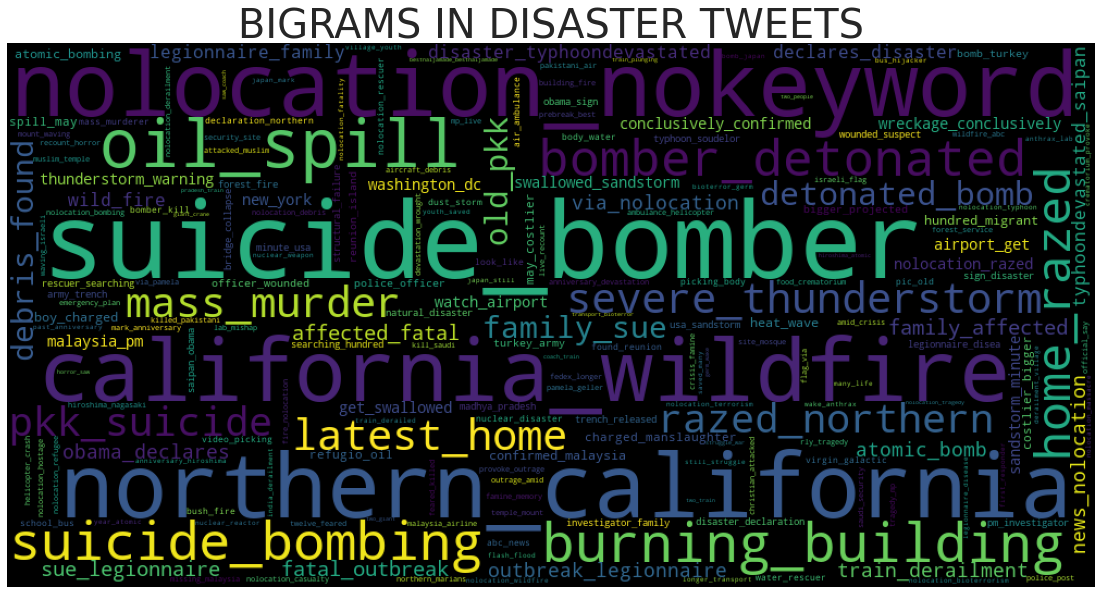

In [ ]:
plot_wordcloud(
    corp_col = 'target' ,
    corp_val = 1 ,
    text_col = 'final_text' ,
    title = 'BIGRAMS IN DISASTER TWEETS',
    df = df,
    bigram = True
)

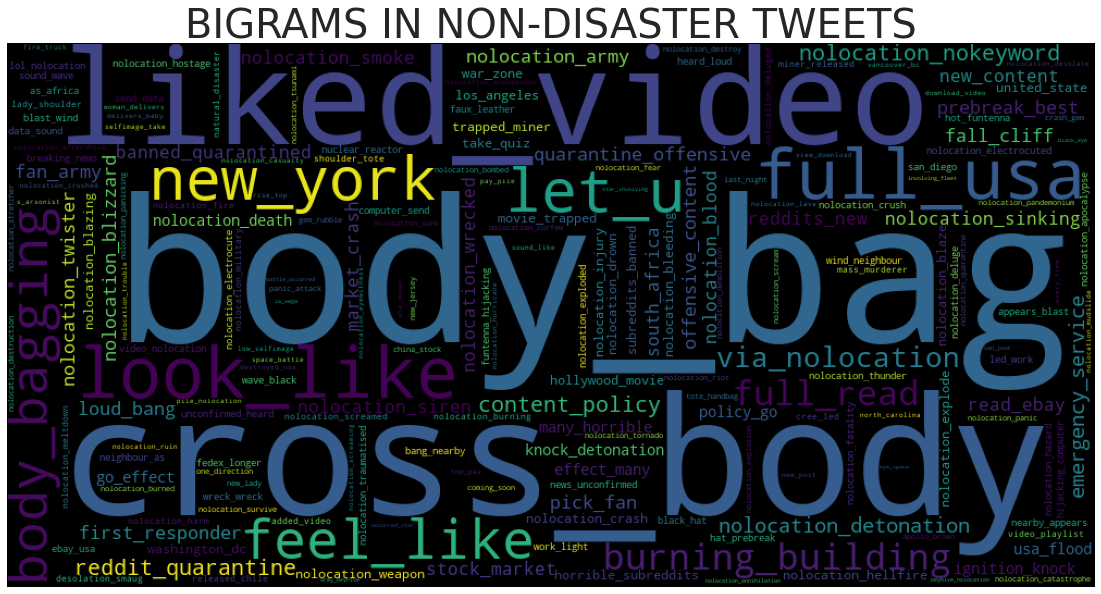

In [ ]:
plot_wordcloud(
    corp_col = 'target' ,
    corp_val = 0 ,
    text_col = 'final_text' ,
    title = 'BIGRAMS IN NON-DISASTER TWEETS',
    df = df,
    bigram = True
)

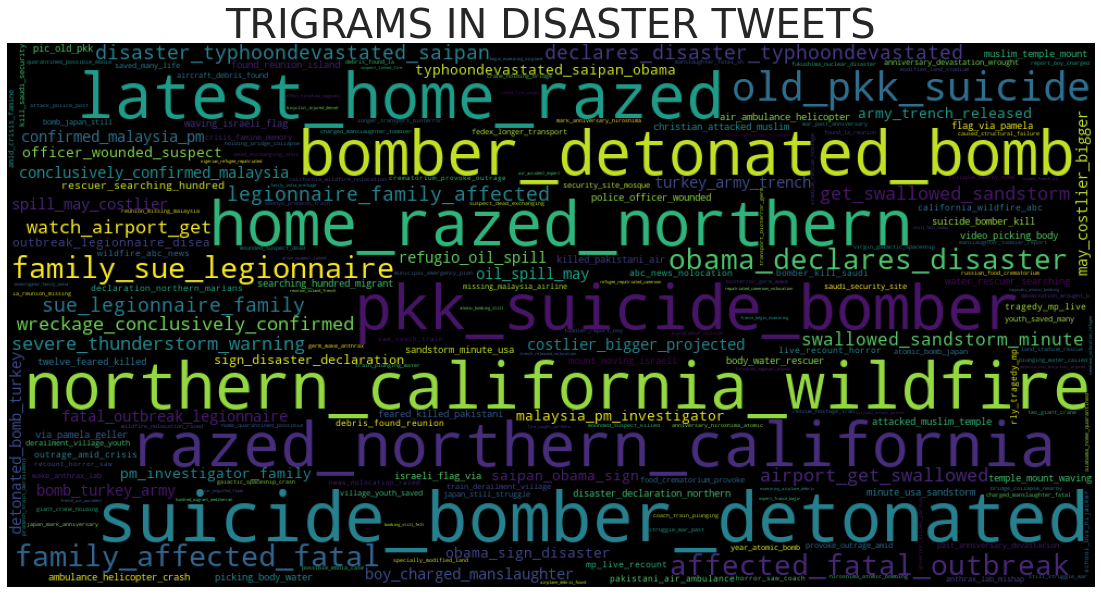

In [ ]:
plot_wordcloud(
    corp_col = 'target' ,
    corp_val = 1 ,
    text_col = 'final_text' ,
    title = 'TRIGRAMS IN DISASTER TWEETS',
    df = df,
    trigram = True
)

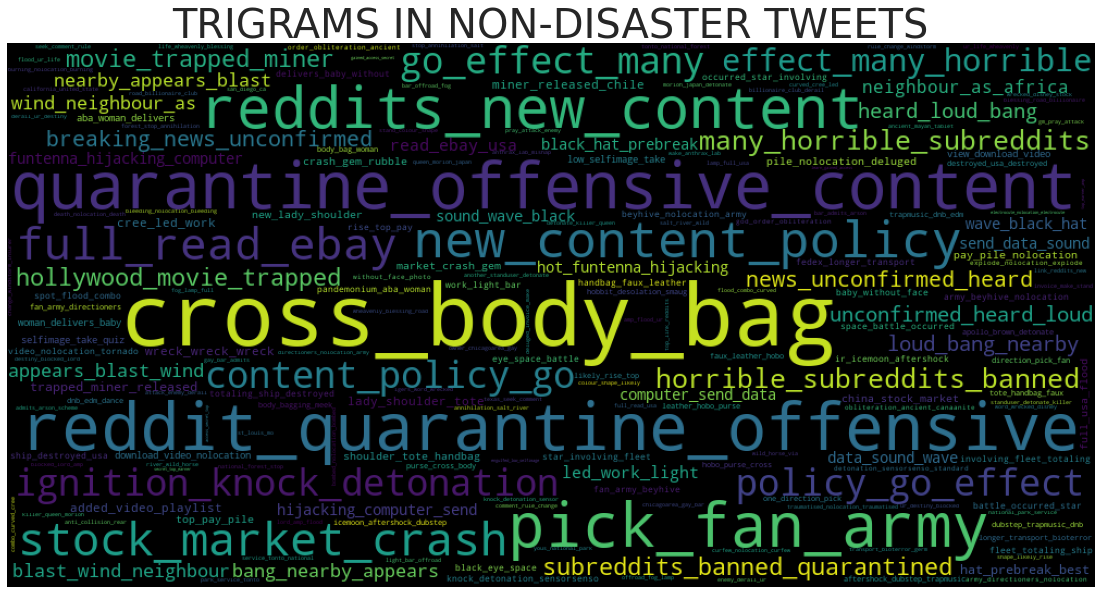

In [ ]:
plot_wordcloud(
    corp_col = 'target' ,
    corp_val = 0 ,
    text_col = 'final_text' ,
    title = 'TRIGRAMS IN NON-DISASTER TWEETS',
    df = df,
    trigram = True
)

In [ ]:
val_split = 0.2
max_len = 30
categories = df['target'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)

word_index = tokenizer.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer.word_index) + 1
print('vocab_size - '+str(vocab_size))

lines_pad = pad_sequences(sequences, maxlen=max_len, padding='post')

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
categories = categories[indices]

num_validation_samples = int(val_split * lines_pad.shape[0])

x_train = lines_pad[:-num_validation_samples]
y_train = categories[:-num_validation_samples]
x_test = lines_pad[-num_validation_samples:]
y_test = categories[-num_validation_samples:]


print('\nShape of x_train:', x_train.shape)
print('Shape of y_train:', y_train.shape)

print('\nShape of x_test:', x_test.shape)
print('Shape of y_test:', y_test.shape)

unique tokens - 14684
vocab_size - 14685

Shape of x_train: (6091, 30)
Shape of y_train: (6091,)

Shape of x_test: (1522, 30)
Shape of y_test: (1522,)


In [ ]:
embeddings_index = {}

f = open('/content/drive/MyDrive/Embeddings/glove.840B.300d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] 
    coefs = np.asarray(values[1:], dtype='float32') 
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')
print(f'Found {str(len(embeddings_index))} word vectors.')

GloVe data loaded
Found 2196017 word vectors.


In [ ]:
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)

In [ ]:
def model1() :  
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(units=64))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid',kernel_initializer='he_uniform'))
    print('MODEL : 1 ----- LSTM')
    model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
    print(model.summary())
    return model

def model2() :  
    model = Sequential()
    model.add(embedding_layer)
    model.add(GRU(units=64))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid',kernel_initializer='he_uniform'))
    print('MODEL : 2 ----- GRU')
    model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
    print(model.summary())
    return model

def model3() :  
    model = Sequential()
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(units=64)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid',kernel_initializer='he_uniform'))
    print('MODEL : 3 ----- BIDIRECTIONAL LSTM')
    model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
    print(model.summary())
    return model

def model4() :  
    model = Sequential()
    model.add(embedding_layer)
    model.add(Bidirectional(GRU(units=64)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid',kernel_initializer='he_uniform'))
    print('MODEL : 4 ----- BIDIRECTIONAL GRU')
    model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
    print(model.summary())
    return model

def model5() :
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(units=64 , return_sequences=True))
    model.add((LSTM(units=64)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid',kernel_initializer='he_uniform'))
    print('MODEL : 5 ----- STACKED LSTM')
    model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
    print(model.summary())
    return model

def model6() :
    model = Sequential()
    model.add(embedding_layer)
    model.add(GRU(units=64 , return_sequences=True))
    model.add((GRU(units=64)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid',kernel_initializer='he_uniform'))
    print('MODEL : 6 ----- STACKED GRU')
    model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
    print(model.summary())
    return model

def model7() :
    model = Sequential()
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(units=64 , return_sequences=True)))
    model.add(Bidirectional((LSTM(units=64))))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid',kernel_initializer='he_uniform'))
    print('MODEL : 7 ----- STACKED BIDIRECTIONAL LSTM')
    model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
    print(model.summary())
    return model

def model8() :
    model = Sequential()
    model.add(embedding_layer)
    model.add(Bidirectional(GRU(units=64 , return_sequences=True)))
    model.add(Bidirectional((GRU(units=64))))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid',kernel_initializer='he_uniform'))
    print('MODEL : 8 ----- STACKED BIDIRECTIONAL GRU')
    model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
    print(model.summary())
    return model

In [ ]:
def get_callbacks(model_name) :  
    LOG_DIR = 'Models'
    PATH = f'logs/fit/{model_name}'

    tb = TensorBoard(log_dir = PATH ,histogram_freq = 1)
    es = EarlyStopping(monitor = 'val_loss' , mode = 'min' , verbose = 1 , patience = 7)
    rlr = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3 , verbose = 1 , factor = 0.5 , min_lr = 0.0000001)

    callbacks = [es,rlr,tb]
    return callbacks

In [ ]:
def save_model(model,model_name) :
    model_json = model.to_json()
    with open(f"{model_name}.json", "w") as json_file:
        json_file.write(model_json)
    print(model_name)
    print('Model Saved')
    model.save_weights(f"{model_name}.h5")
    print('Weights Saved')
    print('*'*200)

In [ ]:
model_1 = model1() 
callbacks = get_callbacks('Model1')
history_1 = model_1.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)
save_model(model_1,'Model1')

model_2 = model2()
callbacks = get_callbacks('Model2')
history_2 = model_2.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)
save_model(model_2,'Model2')

model_3 = model3()
callbacks = get_callbacks('Model3')
history_3 = model_3.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)
save_model(model_3,'Model3')

model_4 = model4()
callbacks = get_callbacks('Model4')
history_4 = model_4.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)
save_model(model_4,'Model4')

model_5 = model5()
callbacks = get_callbacks('Model5')
history_5 = model_5.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)
save_model(model_5,'Model5')

model_6 = model6()
callbacks = get_callbacks('Model6')
history_6 = model_6.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)
save_model(model_6,'Model6')

model_7 = model7()
callbacks = get_callbacks('Model7')
history_7 = model_7.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)
save_model(model_7,'Model7')

model_8 = model8()
callbacks = get_callbacks('Model8')
history_8 = model_8.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)
save_model(model_8,'Model8')

MODEL : 1 ----- LSTM
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 300)           4405500   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                93440     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 4,499,261
Trainable params: 93,633
Non-trainable params: 4,405,628
_________________________________________________________________
None
Epoch 1/50
96/96 [==============================] - 35s 25ms/step - loss: 0.6122 

In [ ]:
def predict(x) :
  pred1 = model_1.predict(x)
  pred1*=100
  pred2 = model_1.predict(x)
  pred2*=100
  pred3 = model_1.predict(x)
  pred3*=100
  pred4 = model_1.predict(x)
  pred4*=100
  pred5 = model_1.predict(x)
  pred5*=100
  pred6 = model_1.predict(x)
  pred6*=100
  pred7 = model_1.predict(x)
  pred7*=100
  pred8 = model_1.predict(x)
  pred8*=100
  pred = pred1[0][0] + pred2[0][0] + pred3[0][0] + pred4[0][0] + pred5[0][0] + pred6[0][0] + pred7[0][0] + pred8[0][0]
  pred /= 8
  return pred 

In [ ]:
def test_predictions(df) :
    counter = 1
    df_len = len(df)
    df = handle_missing_data(df)
    df['final_text'] = df['text'] + '|' + df['location'] + '|' + df['keyword']
    ids = df['id'].values.tolist()
    text = df['final_text'].values.tolist()
    predictions = []
    for t in text :
        content = [t]
        corpus = text_preprocessing(content)
        test_sequences = tokenizer.texts_to_sequences(corpus)
        test_review_pad = pad_sequences(test_sequences, maxlen=max_len, padding='post')
        pred = predict(test_review_pad)
        if pred>=50: predictions.append(1)
        else: predictions.append(0)
        perct = np.round((counter / df_len) * 100 , 2)
        sys.stdout.write('\r'+str(perct)+'%')
        sys.stdout.flush()
        counter += 1
    sys.stdout.write('\r'+''+str(100)+'%')
    sys.stdout.flush()
    results = pd.DataFrame()
    results['id'] = ids
    results['target'] = predictions
    results.to_csv('results.csv', index=False)
    return results

In [ ]:
results = test_predictions(df_test)
results

100%

id  target
0         0       1
1         2       1
2         3       1
3         9       0
4        11       1
...     ...     ...
3258  10861       0
3259  10865       1
3260  10868       1
3261  10874       0
3262  10875       0

[3263 rows x 2 columns]

In [ ]:
plt.figure(figsize=(5,5))
sns.countplot(results['target'],palette=sns.color_palette("bone"));
plt.title('TEST PREDICTION : Disaster tweets vs Non-Disaster tweets count\n' , fontsize=14,);